### Task

This week’s assignment involves running a lasso regression analysis. Lasso regression analysis is a shrinkage and variable selection method for linear regression models. The goal of lasso regression is to obtain the subset of predictors that minimizes prediction error for a quantitative response variable. The lasso does this by imposing a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. Variables with a regression coefficient equal to zero after the shrinkage process are excluded from the model. Variables with non-zero regression coefficients variables are most strongly associated with the response variable. Explanatory variables can be either quantitative, categorical or both.

Your assignment is to run a lasso regression analysis using k-fold cross validation to identify a subset of predictors from a larger pool of predictor variables that best predicts a quantitative response variable.

### Data

Dataset description: hourly rental data spanning two years. 

Dataset can be found at [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data)

Features:
* yr - year
* mnth - month
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weathersit - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* hum - relative humidity
* windspeed (mph) - wind speed, miles per hour
* windspeed (ms) - wind speed, metre per second

Target:
* cnt - number of total rentals

### Results

A lasso regression analysis was conducted to predict a number of total bikes rentals from a pool of 12 categorical and quantitative predictor variables that best predicted a quantitative response variable. Categorical predictors included weather condition and a series of 2 binary categorical variables for holiday and workingday to improve interpretability of the selected model with fewer predictors. 
Quantitative predictor variables include year, month, temperature, humidity and wind speed.

Data were randomly split into a training set that included 70% of the observations and a test set that included 30% of the observations. The least angle regression algorithm with k=10 fold cross validation was used to estimate the lasso regression model in the training set, and the model was validated using the test set. The change in the cross validation average (mean) squared error at each step was used to identify the best subset of predictor variables.

Of the 12 predictor variables, 10 were retained in the selected model:
* atemp: 63.56915200306693
* holiday: -282.431748735072
* hum: -12.815264427009353
* mnth: 0.0
* season: 381.77762475080044
* temp: 58.035647703871234
* weathersit: -514.6381162101678
* weekday: 69.84812053893549
* windspeed(mph): 0.0
* windspeed(ms): -95.71090321577515
* workingday: 36.15135752613271
* yr: 2091.5182927517903

Train data R-square 0.7899877818517489   
Test data R-square 0.8131871527614188

During the estimation process, year and season were most strongly associated with the number of total bikes rentals, followed by temperature and weekday. Holiday, humidity, weather condition and wind speed (ms) were negatively associated with the number of total bikes rentals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline 

rnd_state = 983

In [2]:
data = pd.read_csv("data/bikes_rent.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
season            731 non-null int64
yr                731 non-null int64
mnth              731 non-null int64
holiday           731 non-null int64
weekday           731 non-null int64
workingday        731 non-null int64
weathersit        731 non-null int64
temp              731 non-null float64
atemp             731 non-null float64
hum               731 non-null float64
windspeed(mph)    731 non-null float64
windspeed(ms)     731 non-null float64
cnt               731 non-null int64
dtypes: float64(5), int64(8)
memory usage: 74.3 KB


In [3]:
data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872077,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


In [4]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [5]:
data.dropna(inplace=True)

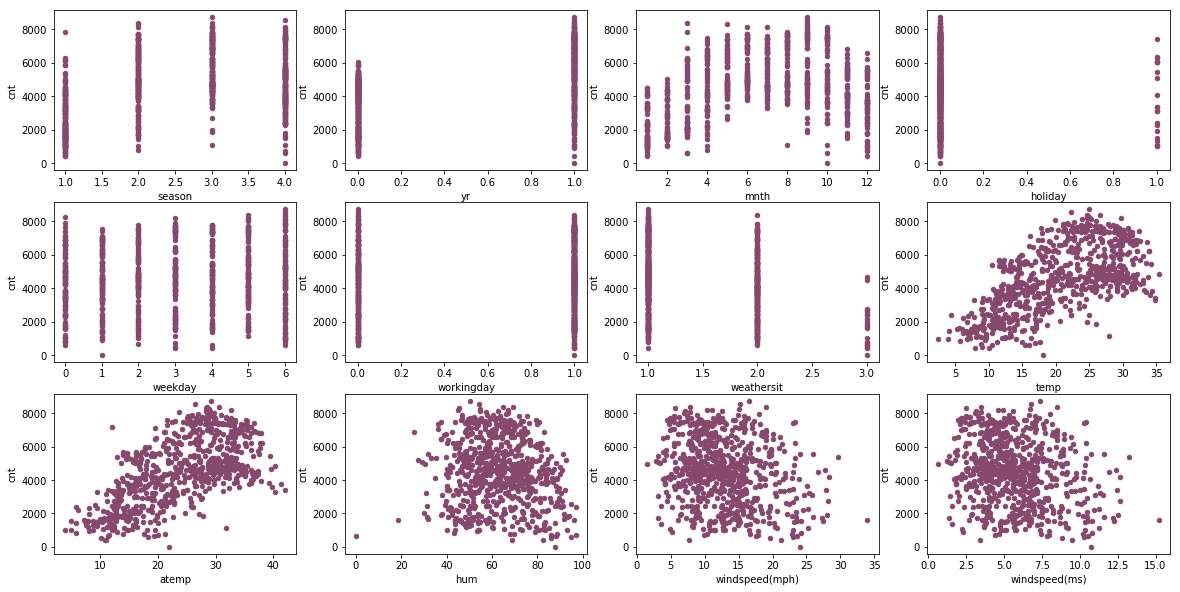

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for idx, feature in enumerate(data.columns.values[:-1]):
    data.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[int(idx / 4), idx % 4], c='#87486e');

The plot above shows that there is a linear dependence between temp, atemp and cnt features. The correlations below confirm that observation.

In [7]:
data.iloc[:, :12].corrwith(data['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

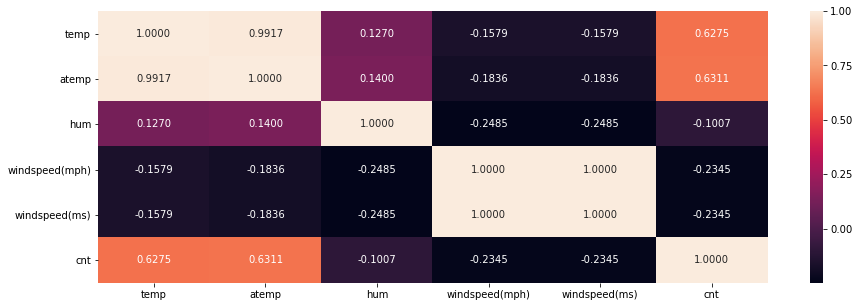

In [8]:
plt.figure(figsize=(15, 5))
sns.heatmap(data[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr(), annot=True, fmt='1.4f');

There is a strong correlation between temp and atemp, as well as windspeed(mph) and windspeed(ms) features, due to the fact that they represent similar metrics in different measures. In further analysis two of those features must be dropped or applyed with penalty (L2 or Lasso regression).

In [9]:
predictors = data.iloc[:, :12]
target = data['cnt']

In [10]:
(predictors_train, predictors_test,
 target_train, target_test) = train_test_split(predictors, target, test_size = .3, random_state = rnd_state)

In [11]:
model = LassoLarsCV(cv=10, precompute=False).fit(predictors_train, target_train)

In [12]:
dict(zip(predictors.columns, model.coef_))

{'atemp': 63.56915200306693,
 'holiday': -282.431748735072,
 'hum': -12.815264427009353,
 'mnth': 0.0,
 'season': 381.77762475080044,
 'temp': 58.035647703871234,
 'weathersit': -514.6381162101678,
 'weekday': 69.84812053893549,
 'windspeed(mph)': 0.0,
 'windspeed(ms)': -95.71090321577515,
 'workingday': 36.15135752613271,
 'yr': 2091.5182927517903}

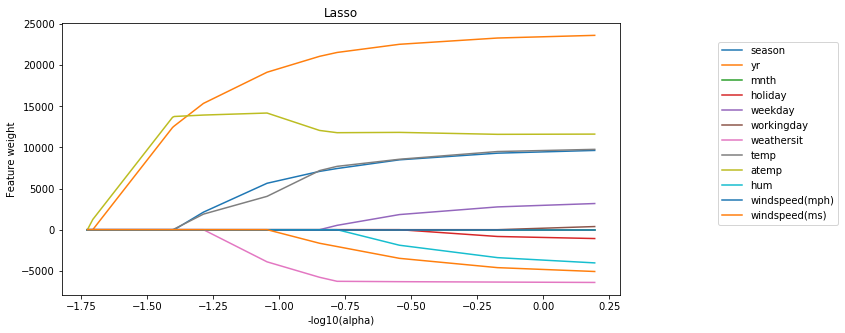

In [13]:
log_alphas = -np.log10(model.alphas_)
plt.figure(figsize=(10, 5))
for idx, feature in enumerate(predictors.columns):
    plt.plot(log_alphas, list(map(lambda r: r[idx], model.coef_path_.T)), label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("-log10(alpha)")
plt.ylabel("Feature weight")
plt.title("Lasso");

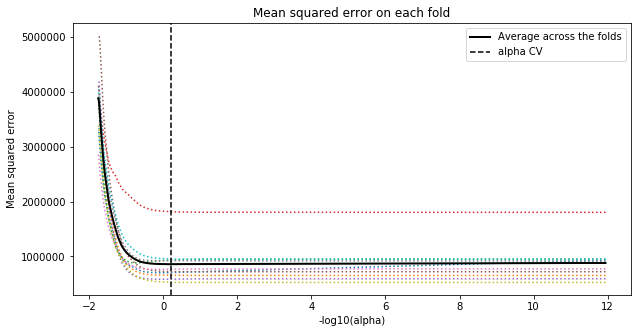

In [14]:
log_cv_alphas = -np.log10(model.cv_alphas_)
plt.figure(figsize=(10, 5))
plt.plot(log_cv_alphas, model.mse_path_, ':')
plt.plot(log_cv_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log10(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold');

In [16]:
rsquared_train = model.score(predictors_train, target_train)
rsquared_test = model.score(predictors_test, target_test)
print('Train data R-square', rsquared_train)
print('Test data R-square', rsquared_test)

Train data R-square 0.7899877818517489
Test data R-square 0.8131871527614188
